# LEGO Minifigures Classification

## Data
The dataset is a collection of images of various Lego minifigures. Each image is 512x512 pixels and there are 37 classes. 

In [1]:
import os
import math
import numpy as np
import time
import matplotlib.pyplot as plt
from PIL import Image

seed = 1234
np.random.seed(seed)

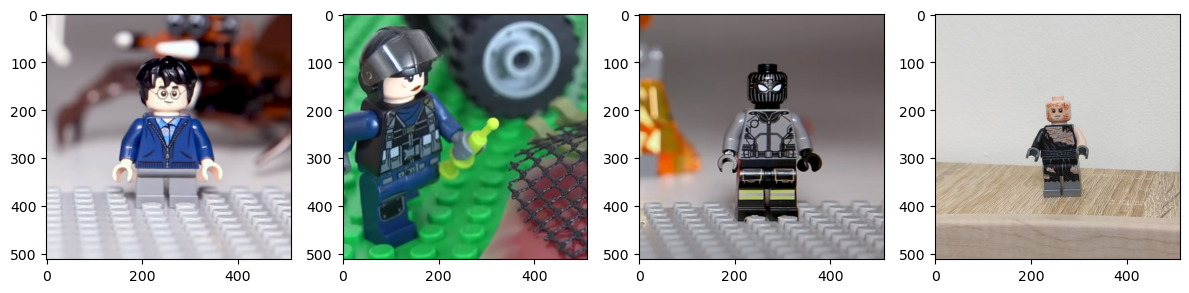

In [2]:
# Example of input images

image1 = np.asarray(Image.open('/kaggle/input/lego-minifigures-classification/harry-potter/0001/002.jpg'))
image2 = np.asarray(Image.open('/kaggle/input/lego-minifigures-classification/jurassic-world/0002/002.jpg'))
image3 = np.asarray(Image.open('/kaggle/input/lego-minifigures-classification/marvel/0007/002.jpg'))
image4 = np.asarray(Image.open('/kaggle/input/lego-minifigures-classification/star-wars/0014/002.jpg'))

fig, axs = plt.subplots(1, 4, figsize=(12, 3))
axs[0].imshow(image1)
axs[1].imshow(image2)
axs[2].imshow(image3)
axs[3].imshow(image4)

plt.tight_layout()
plt.show()

In [3]:
# Make training and validation sets
# Training is 80% and validation is 20% of the input

import pandas as pd
import sklearn.model_selection

kaggle_path = "/kaggle/input/lego-minifigures-classification/"
index_path = kaggle_path+"index.csv"

index = pd.read_csv(index_path)
# index = index[index['class_id'] <= 10]

targets = index["class_id"].values

train, valid = sklearn.model_selection.train_test_split(index, train_size=0.8, random_state = seed, stratify=targets)
train_X = [kaggle_path+p for p in train["path"].values]
train_y = train["class_id"].values
valid_X = [kaggle_path+p for p in valid["path"].values]
valid_y = valid["class_id"].values
print("Train size:", len(train_y))
print("Validation size:", len(valid_y))

Train size: 296
Validation size: 75


In [4]:
# Labels

# metadata.csv in lego-minifigures-classification has ` instead of ' which creates an error
# metadata_path = kaggle_path+"metadata.csv"
# metadata = pd.read_csv(metadata_path)

import codecs
f = codecs.open("/kaggle/input/lego-metadata/metadata_neeraj.csv", 'r', encoding='utf-8')
metadata = f.read()
labels = metadata[3]

In [5]:
# Tests
test_path = kaggle_path+"test.csv"
test = pd.read_csv(test_path)
test_X = test["path"].values
test_y = test["class_id"].values
print("Test size:", len(test_y))

Test size: 79


## CNN

In [6]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
torch.manual_seed(seed)

class LegoDataset(Dataset):
    def __init__(self, train = False, valid = False, test = False, transform=None):
        self.data, self.labels = None, None
        if train:
            self.data = train_X
            self.labels = train_y
        if valid:
            self.data = valid_X
            self.labels = valid_y
        if test:
            self.data = test_X
            self.labels = test_y
        self.transform = transform
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = np.copy(np.asarray(Image.open(self.data[idx])))
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [7]:
train_transform = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to a tensor
#     transforms.RandomResizedCrop(500),  # Randomly crop the image and resize it to 224x224
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip the image horizontally
    transforms.RandomRotation(15),  # Randomly rotate the image by 10 degrees
#     transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05, hue=0.0),  # Adjust color jitter
#     transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2)),
#     transforms.RandomPerspective(distortion_scale=0.6, p=0.5),
#     transforms.RandomAdjustSharpness(sharpness_factor=2),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the image
])

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = LegoDataset(train = True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

validset = LegoDataset(valid = True, transform=transform)
validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = LegoDataset(test = True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

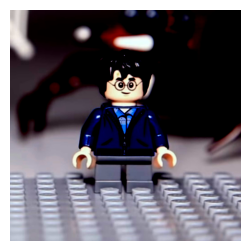

In [8]:
# Normal Tensor
image = Image.open('/kaggle/input/lego-minifigures-classification/harry-potter/0001/002.jpg')
image = transform(image)
fig, axes = plt.subplots(1, 1, figsize=(3, 3))

# Display the augmented image
# plt.imshow(transforms.ToPILImage()(image))
plt.imshow(np.moveaxis(image.cpu().numpy(), 0, -1))
# plt.imshow(np.transpose(image.numpy(), (1,2,0)))
plt.axis('off')
plt.show()

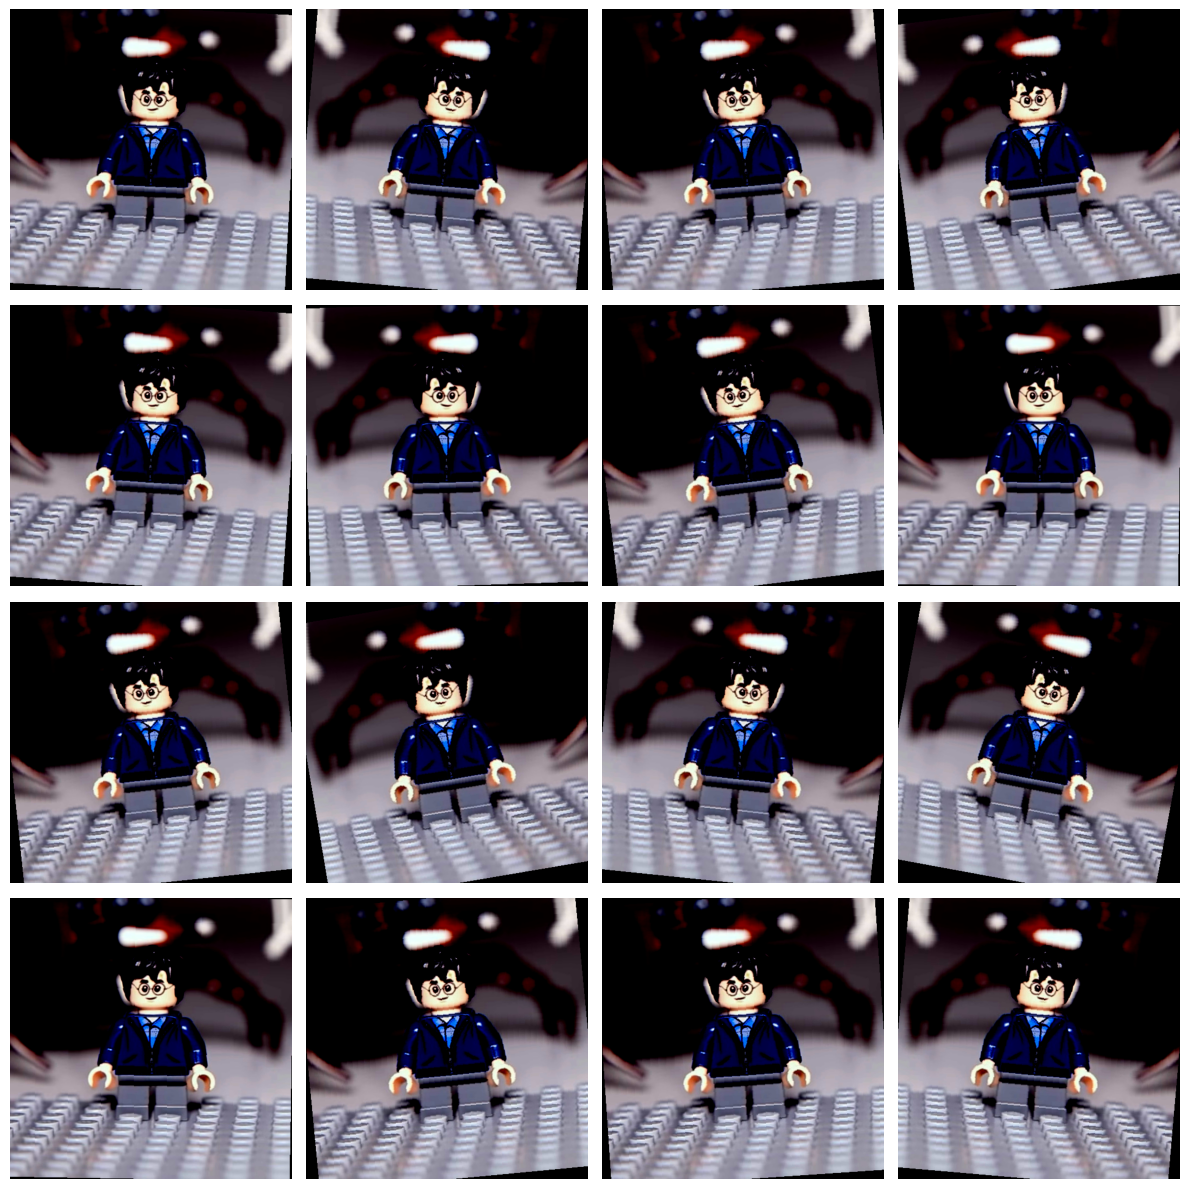

In [9]:
## Data Augmentation
image = Image.open('/kaggle/input/lego-minifigures-classification/harry-potter/0001/002.jpg')
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

for i in range(4):
    for j in range(4): 
        augmented_image = train_transform(image)
        axes[j,i].imshow(np.moveaxis(augmented_image.cpu().numpy(), 0, -1))
        axes[j,i].axis('off')

plt.tight_layout()
plt.show()

import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 7)
        self.conv2 = nn.Conv2d(32, 64, 7)
        self.conv3 = nn.Conv2d(64, 128, 7)
        self.conv4 = nn.Conv2d(128, 256, 3)
        self.conv5 = nn.Conv2d(256, 512, 3)
        self.conv6 = nn.Conv2d(512, 1024, 3)
        self.fc1 = nn.Linear(640000, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 39)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.dropout = nn.Dropout(0.5)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.bn2(x)
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = F.relu(self.conv6(x))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)
print(device)

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.00005, momentum=0.9)

for epoch in range(1):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i == 73:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 74:.3f}')
            running_loss = 0.0

print('Finished Training')

In [10]:
from torchvision.models import mobilenet_v2
import torch.nn as nn
import torch.optim as optim

net = mobilenet_v2()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = net.to(device)
criterion = criterion.to(device)

In [12]:
for epoch in range(200):
    net.train()
    running_loss = 0.0
    
    for i, data in enumerate(trainloader):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if (i + 1) % 70 == 0:
            print(f"Epoch [{epoch + 1}], Step [{i + 1}/{len(trainloader)}], Loss: {running_loss / 70:.4f}")
            running_loss = 0.0

    if epoch % 10 == 0:
        net.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data in validloader:
                inputs, labels = data[0].to(device), data[1].to(device)
                outputs = net(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = 100 * correct / total
        print(f"Validation Accuracy: {val_accuracy:.2f}%")

Epoch [1], Step [70/74], Loss: 4.7700
Validation Accuracy: 2.67%
Epoch [2], Step [70/74], Loss: 3.6561
Epoch [3], Step [70/74], Loss: 3.5390
Epoch [4], Step [70/74], Loss: 3.4464
Epoch [5], Step [70/74], Loss: 3.4698
Epoch [6], Step [70/74], Loss: 3.3470
Epoch [7], Step [70/74], Loss: 3.3924
Epoch [8], Step [70/74], Loss: 3.2255
Epoch [9], Step [70/74], Loss: 3.2458
Epoch [10], Step [70/74], Loss: 3.2085
Epoch [11], Step [70/74], Loss: 3.2301
Validation Accuracy: 12.00%
Epoch [12], Step [70/74], Loss: 3.2192
Epoch [13], Step [70/74], Loss: 3.1684
Epoch [14], Step [70/74], Loss: 3.0940
Epoch [15], Step [70/74], Loss: 3.1513
Epoch [16], Step [70/74], Loss: 3.0660
Epoch [17], Step [70/74], Loss: 3.0087
Epoch [18], Step [70/74], Loss: 3.0476
Epoch [19], Step [70/74], Loss: 3.0238
Epoch [20], Step [70/74], Loss: 2.9863
Epoch [21], Step [70/74], Loss: 2.9436
Validation Accuracy: 12.00%
Epoch [22], Step [70/74], Loss: 2.9604
Epoch [23], Step [70/74], Loss: 2.9777
Epoch [24], Step [70/74], Los

In [13]:
# Training set Accuracy
correct = 0
total = 0
with torch.no_grad():
    for data in trainloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on training images: {100 * correct // total} %')

Accuracy of the network on training images: 95 %


In [14]:
# Validation Set Accuracy
correct = 0
total = 0
labels_all = []
pred_all = []
with torch.no_grad():
    for data in validloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
#         print("Correct:",labels,"Predicted:",predicted)
        labels_all.extend(labels.cpu().numpy())
        pred_all.extend(predicted.cpu().numpy())

print(f'Accuracy of the network on validation images: {100 * correct // total} %')

Accuracy of the network on validation images: 41 %


In [15]:
# Top 3 Accuracy
correct = 0
total = 0
with torch.no_grad():
    for data in validloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.topk(outputs.data, 3, 1, True, True)
        top_correct = predicted.eq(labels.view(-1, 1).expand_as(predicted))
        top_correct = top_correct.sum(0).float()
        total += labels.size(0)
        correct += top_correct.sum().item()

print(f'Top 3 Accuracy of the network on validation images: {100 * correct // total} %')

Top 3 Accuracy of the network on validation images: 77.0 %


In [16]:
# Top 5 Accuracy
correct = 0
total = 0
with torch.no_grad():
    for data in validloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.topk(outputs.data, 5, 1, True, True)
        top_correct = predicted.eq(labels.view(-1, 1).expand_as(predicted))
        top_correct = top_correct.sum(0).float()
        total += labels.size(0)
        correct += top_correct.sum().item()

print(f'Top 5 Accuracy of the network on validation images: {100 * correct // total} %')

Top 5 Accuracy of the network on validation images: 84.0 %


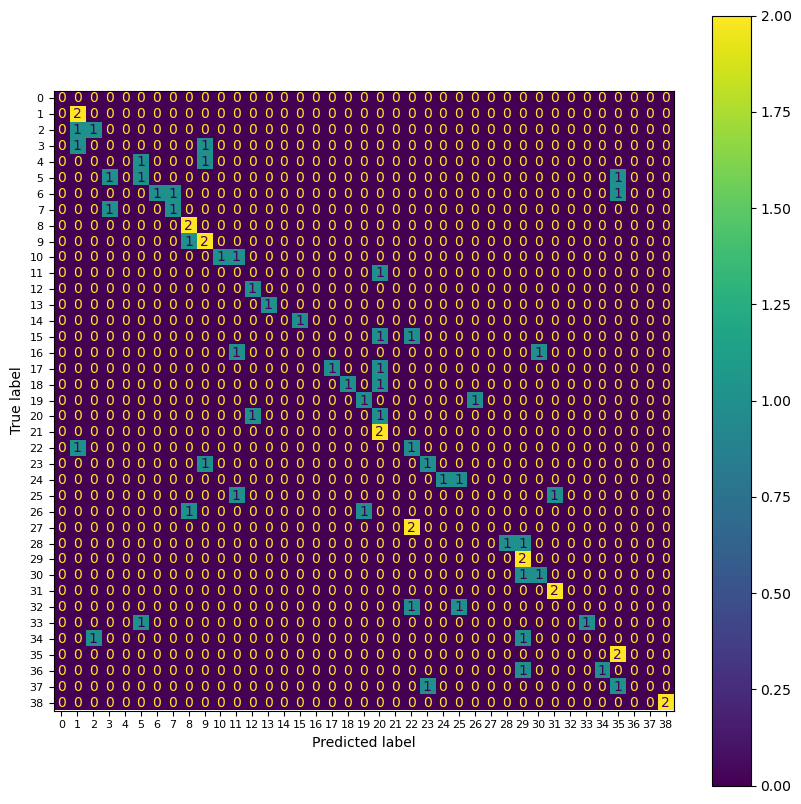

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10,10))
cfm = ConfusionMatrixDisplay.from_predictions(labels_all, pred_all, ax=ax, labels=range(39))
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()